# Objective

Given the dataset of **Christiano Ronaldo's** "attempts" on the goal target, predict if he **scored a goal or not**. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn import metrics, preprocessing, model_selection
import lightgbm as lgb

from fancyimpute import KNN

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()

import matplotlib.pyplot as plt
from fancyimpute import KNN

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['cristano_ronaldo_final_v1']


In [2]:
# set seed for reproducibility
np.random.seed(0) 

# Read the dataset

ronaldo_train_df = pd.read_csv("../input/cristano_ronaldo_final_v1/data.csv",index_col=0)

print("ronaldo_train_dataframe -  rows:",ronaldo_train_df.shape[0]," columns:", ronaldo_train_df.shape[1])

ronaldo_train_dataframe -  rows: 30697  columns: 27


## Exploratory Data Analysis

In [3]:
# view first 5 rows of the dataset

ronaldo_train_df.head()

,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,game_season,remaining_sec,distance_of_shot,is_goal,area_of_shot,shot_basics,range_of_shot,team_name,date_of_game,home/away,shot_id_number,lat/lng,type_of_shot,type_of_combined_shot,match_id,team_id,remaining_min.1,power_of_shot.1,knockout_match.1,remaining_sec.1,distance_of_shot.1
0,10.0,167.0,72.0,10.0,1.0,0.0,2000-01,27.0,38.0,NaN,Right Side(R),Mid Range,16-24 ft.,Manchester United,2000-10-31,MANU @ POR,1.0,"45.539131, -122.651648",shot - 30,NaN,20000012,1610612747,10.00,1.0,50.608,54.2000,38.0
1,12.0,-157.0,0.0,10.0,1.0,0.0,2000-01,22.0,35.0,0.0,Left Side(L),Mid Range,8-16 ft.,Manchester United,2000-10-31,MANU @ POR,2.0,"45.539131, -122.651648",shot - 45,NaN,20000012,1610612747,10.00,1.0,28.800,22.0000,35.0
2,35.0,-101.0,135.0,7.0,1.0,0.0,2000-01,45.0,36.0,1.0,Left Side Center(LC),Mid Range,16-24 ft.,Manchester United,2000-10-31,NaN,3.0,"45.539131, -122.651648",shot - 25,NaN,20000012,1610612747,92.64,1.0,0.000,63.7216,54.4
3,43.0,138.0,175.0,6.0,1.0,0.0,2000-01,52.0,42.0,0.0,Right Side Center(RC),Mid Range,16-24 ft.,Manchester United,2000-10-31,MANU @ POR,4.0,"45.539131, -122.651648",NaN,shot - 3,20000012,1610612747,NaN,1.0,122.608,52.0000,42.0
4,155.0,0.0,0.0,NaN,2.0,0.0,2000-01,19.0,20.0,1.0,Center(C),Goal Area,Less Than 8 ft.,NaN,2000-10-31,MANU @ POR,5.0,"45.539131, -122.651648",NaN,shot - 1,20000012,1610612747,42.64,2.0,0.000,19.0000,20.0


In [4]:
# Let's get an overall idea of the dataset

ronaldo_train_df.describe()

,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,remaining_sec,distance_of_shot,is_goal,shot_id_number,match_id,team_id,remaining_min.1,power_of_shot.1,knockout_match.1,remaining_sec.1,distance_of_shot.1
count,29134.000000,29236.000000,29157.000000,29135.000000,29211.000000,29180.000000,29103.000000,29130.000000,24429.000000,29134.000000,3.069700e+04,3.069700e+04,29162.000000,29158.000000,29204.000000,29158.000000,29129.000000
mean,249.576028,7.383876,91.126933,4.883233,2.519359,0.145956,28.329382,33.448884,0.445331,15368.581039,2.476407e+07,1.610613e+09,18.204615,15.994109,16.599402,39.027303,38.801852
std,150.186019,110.263049,87.676395,3.452533,1.153976,0.353068,17.470663,9.369656,0.497013,8866.520772,7.755175e+06,0.000000e+00,29.416973,29.676815,35.172016,29.835284,18.787711
min,2.000000,-250.000000,-44.000000,0.000000,1.000000,0.000000,0.000000,20.000000,0.000000,1.000000,2.000001e+07,1.610613e+09,0.000000,1.000000,0.000000,0.000000,9.400000
25%,111.000000,-68.000000,4.000000,2.000000,1.000000,0.000000,13.000000,25.000000,0.000000,7693.250000,2.050008e+07,1.610613e+09,3.000000,2.000000,0.000000,17.000000,26.000000
50%,254.000000,0.000000,74.000000,5.000000,3.000000,0.000000,28.000000,35.000000,0.000000,15378.500000,2.090035e+07,1.610613e+09,6.000000,3.000000,0.000000,35.000000,36.000000
75%,369.000000,95.000000,160.000000,8.000000,3.000000,0.000000,43.000000,41.000000,1.000000,23055.750000,2.960047e+07,1.610613e+09,11.000000,4.000000,1.000000,52.000000,44.000000
max,659.000000,248.000000,791.000000,11.000000,7.000000,1.000000,59.000000,99.000000,1.000000,30697.000000,4.990009e+07,1.610613e+09,128.761600,118.360000,141.352320,144.785600,115.728000


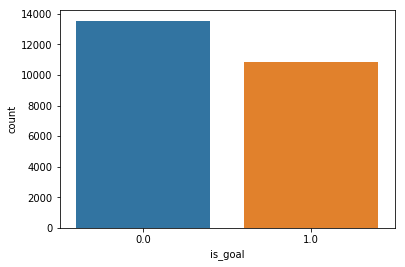

In [5]:
# check target variable is_goal

sns.countplot(ronaldo_train_df['is_goal'])

Okay, so we have a balanced dataset here. 

## Split Train - Test Dataset

In [6]:
# Correct short_id_number and set it to index+1

ronaldo_train_df['shot_id_number'] = ronaldo_train_df.index + 1

In [7]:
# Extract test dataframe

ronaldo_test_df = ronaldo_train_df[ronaldo_train_df['is_goal'].isnull()]
print(f'Test dataframe shape: {ronaldo_test_df.shape}')

Test dataframe shape: (6268, 27)


In [8]:
# Drop the is_goal column as it is no longer needed in test dataset

ronaldo_test_df = ronaldo_test_df.drop(['is_goal'], axis=1)
ronaldo_test_df.head()

,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,game_season,remaining_sec,distance_of_shot,area_of_shot,shot_basics,range_of_shot,team_name,date_of_game,home/away,shot_id_number,lat/lng,type_of_shot,type_of_combined_shot,match_id,team_id,remaining_min.1,power_of_shot.1,knockout_match.1,remaining_sec.1,distance_of_shot.1
0,10.0,167.0,72.0,10.0,1.0,0.0,2000-01,27.0,38.0,Right Side(R),Mid Range,16-24 ft.,Manchester United,2000-10-31,MANU @ POR,1,"45.539131, -122.651648",shot - 30,NaN,20000012,1610612747,10.00,1.00,50.608,54.2,38.0
7,254.0,1.0,28.0,8.0,3.0,0.0,2000-01,5.0,22.0,Center(C),Goal Area,Less Than 8 ft.,Manchester United,2000-10-31,MANU @ POR,8,"45.539131, -122.651648",NaN,shot - 3,20000012,1610612747,68.64,3.00,0.000,5.0,22.0
16,100.0,0.0,0.0,0.0,1.0,0.0,2000-01,1.0,20.0,NaN,Goal Area,Less Than 8 ft.,Manchester United,2000-11-01,MANU vs. UTA,17,"42.982923, -71.446094",NaN,shot - 4,20000019,1610612747,0.00,1.00,0.000,1.0,20.0
19,249.0,0.0,0.0,10.0,3.0,0.0,NaN,46.0,20.0,Center(C),NaN,Less Than 8 ft.,Manchester United,2000-11-01,MANU vs. UTA,20,"42.982923, -71.446094",shot - 4,NaN,20000019,1610612747,10.00,70.36,0.000,46.0,20.0
21,265.0,134.0,127.0,9.0,3.0,0.0,NaN,4.0,38.0,Right Side Center(RC),Mid Range,16-24 ft.,Manchester United,2000-11-01,MANU vs. UTA,22,"42.982923, -71.446094",shot - 24,NaN,20000019,1610612747,9.00,43.36,0.000,4.0,38.0


In [9]:
# We drop all the rows that contains NaN values

ronaldo_train_df = ronaldo_train_df.dropna(subset=['is_goal']) 

Now we have final `ronaldo_train_df` and `ronaldo_test_df`

In [10]:
print(f'Training dataset shape is: {ronaldo_train_df.shape}')
print(f'Test dataset shape is: {ronaldo_test_df.shape}')

Training dataset shape is: (24429, 27)
Test dataset shape is: (6268, 26)


In [11]:
# check for NaN values

ronaldo_train_df.isnull().sum()

match_event_id            1240
location_x                1156
location_y                1245
remaining_min             1244
power_of_shot             1200
knockout_match            1212
game_season               4632
remaining_sec             1250
distance_of_shot          1257
is_goal                      0
area_of_shot              1182
shot_basics               1283
range_of_shot             1248
team_name                 1212
date_of_game              1237
home/away                 1214
shot_id_number               0
lat/lng                   1247
type_of_shot             12136
type_of_combined_shot    12293
match_id                     0
team_id                      0
remaining_min.1           1209
power_of_shot.1           1208
knockout_match.1          1214
remaining_sec.1           1200
distance_of_shot.1        1244
dtype: int64

Well, we can clearly see that some columns have huge missing values.

In [12]:
# To check what kind of variables are we dealing with - float (continuous) and object(categorial)

pd.options.display.max_rows = 30

dtype_df = ronaldo_train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,match_event_id,float64
1,location_x,float64
2,location_y,float64
3,remaining_min,float64
4,power_of_shot,float64
5,knockout_match,float64
6,game_season,object
7,remaining_sec,float64
8,distance_of_shot,float64
9,is_goal,float64


In [13]:
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,3
1,float64,14
2,object,10


In [14]:
# Check value counts of categorical variables

for i in ronaldo_train_df.columns:
    if ronaldo_train_df[i].dtype=="object":
        print (ronaldo_train_df[i].value_counts())

2005-06    1496
2002-03    1429
2008-09    1416
2007-08    1403
2009-10    1374
2001-02    1310
2006-07    1233
2000-01    1195
2010-11    1153
2011-12    1093
2003-04    1047
2012-13    1044
1999-00     992
2004-05     871
2015-16     714
1997-98     627
1998-99     590
2014-15     474
1996-97     291
2013-14      45
Name: game_season, dtype: int64
Center(C)                10177
Right Side Center(RC)     3616
Right Side(R)             3504
Left Side Center(LC)      3031
Left Side(L)              2848
Mid Ground(MG)              71
Name: area_of_shot, dtype: int64
Mid Range          9488
Goal Area          5323
Penalty Spot       4245
Goal Line          3515
Right Corner        302
Left Corner         216
Mid Ground Line      57
Name: shot_basics, dtype: int64
Less Than 8 ft.    7064
16-24 ft.          6220
8-16 ft.           5076
24+ ft.            4751
Back Court Shot      70
Name: range_of_shot, dtype: int64
Manchester United    23217
Name: team_name, dtype: int64
2016-04-13    39
2

## Univariate Analysis

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


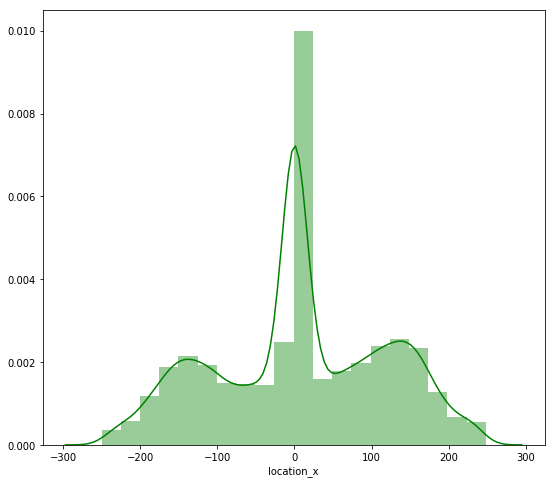

In [15]:
plt.figure(figsize=(9, 8))
sns.distplot(ronaldo_train_df['location_x'], color='g', bins=20, hist_kws={'alpha': 0.4});

In [16]:
# Let's work on numerical dataframe

df_num = ronaldo_train_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,remaining_sec,distance_of_shot,is_goal,shot_id_number,match_id,team_id,remaining_min.1,power_of_shot.1,knockout_match.1,remaining_sec.1,distance_of_shot.1
1,12.0,-157.0,0.0,10.0,1.0,0.0,22.0,35.0,0.0,2,20000012,1610612747,10.00,1.0,28.800,22.0000,35.0
2,35.0,-101.0,135.0,7.0,1.0,0.0,45.0,36.0,1.0,3,20000012,1610612747,92.64,1.0,0.000,63.7216,54.4
3,43.0,138.0,175.0,6.0,1.0,0.0,52.0,42.0,0.0,4,20000012,1610612747,NaN,1.0,122.608,52.0000,42.0
4,155.0,0.0,0.0,NaN,2.0,0.0,19.0,20.0,1.0,5,20000012,1610612747,42.64,2.0,0.000,19.0000,20.0
5,244.0,-145.0,-11.0,9.0,3.0,0.0,32.0,34.0,0.0,6,20000012,1610612747,9.00,3.0,0.000,NaN,34.0


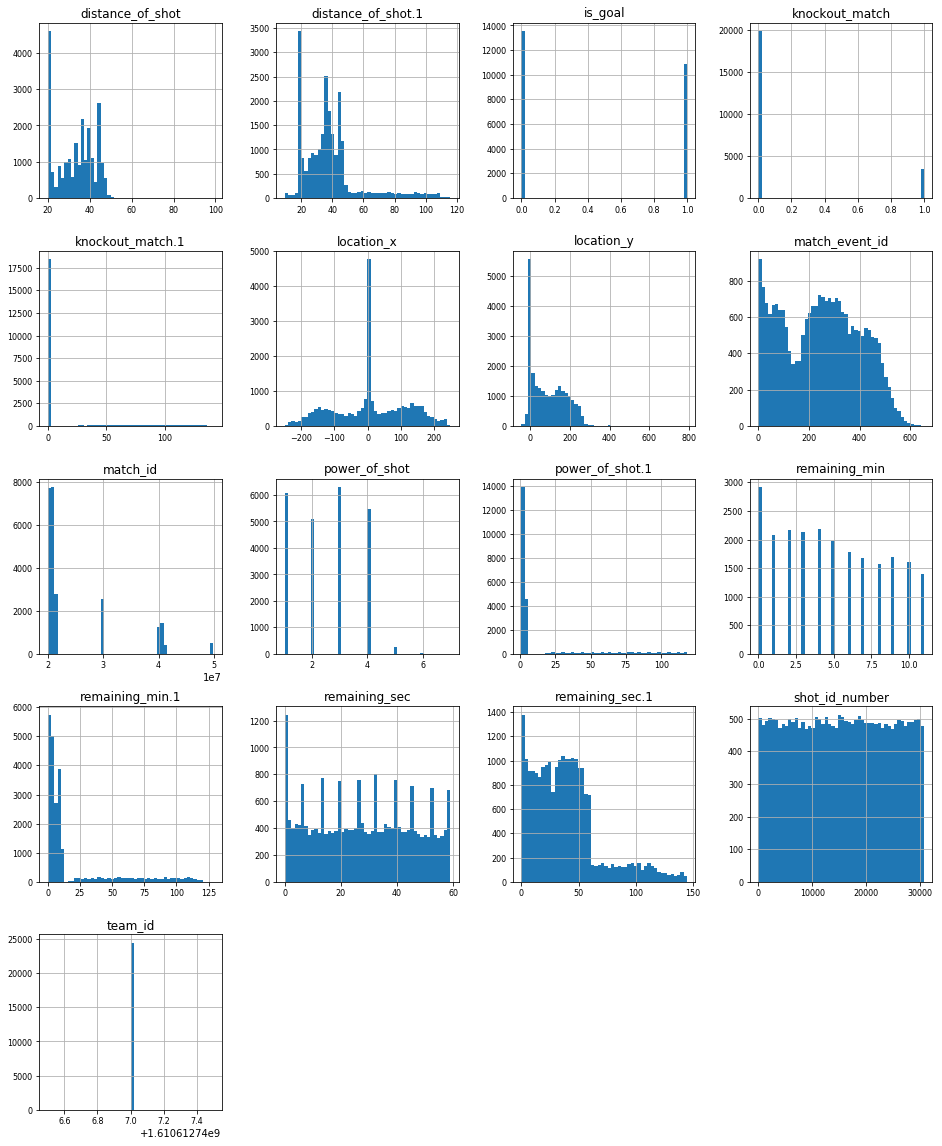

In [17]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # avoid having the matplotlib verbose informations

From this we can conclude that there are some categorical columns that are being represented as continuous.

- team_id is not adding any new information so we can drop it.
- Convert some columns to categorical type for ex: knockout_match,is_goal,power_shot,remaining_min

In [18]:
# convert object type to categorical

for col in ['is_goal', 'knockout_match', 'power_of_shot', 'remaining_min']:
    ronaldo_train_df[col] = ronaldo_train_df[col].astype('category')
    
for col in ['knockout_match', 'power_of_shot', 'remaining_min']:
    ronaldo_test_df[col] = ronaldo_test_df[col].astype('category')

In [19]:
# Drop some columns in train and test dataframe

ronaldo_train_df = ronaldo_train_df.drop(['match_id','team_id'],axis=1)
ronaldo_test_df = ronaldo_test_df.drop(['match_id','team_id'],axis=1)

In [20]:
df_num = df_num.drop(['is_goal', 'knockout_match', 'power_of_shot', 'remaining_min'],axis=1)

## Feature to feature relationship



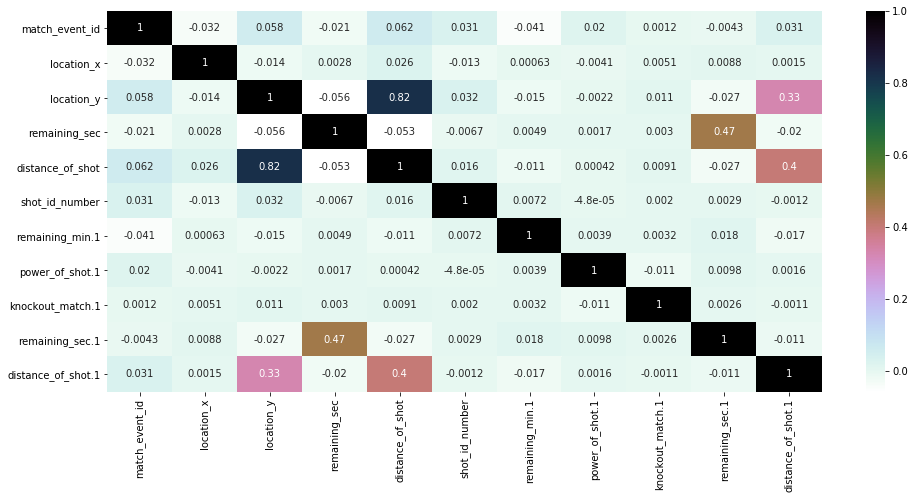

In [21]:
plt.figure(figsize=(16,7)) 
sns.heatmap(ronaldo_train_df.corr(),annot=True,cmap='cubehelix_r') #draws  heatmap with input as the correlation matrix calculted.
plt.show()

Hence we can see that `distance_of_shot` and `location_y` is highly correlated. Highly correlated feature do not increase the preditive model accuracy so we have to remove one of them.

**Note**: If two features are higly correlated then we will remove one of them as it does not increase the predictive capability of the model.


In [22]:
# Let's work on categorical dataframe

df_cat = ronaldo_train_df.select_dtypes(include = ['O'])
df_cat.head()

,game_season,area_of_shot,shot_basics,range_of_shot,team_name,date_of_game,home/away,lat/lng,type_of_shot,type_of_combined_shot
1,2000-01,Left Side(L),Mid Range,8-16 ft.,Manchester United,2000-10-31,MANU @ POR,"45.539131, -122.651648",shot - 45,NaN
2,2000-01,Left Side Center(LC),Mid Range,16-24 ft.,Manchester United,2000-10-31,NaN,"45.539131, -122.651648",shot - 25,NaN
3,2000-01,Right Side Center(RC),Mid Range,16-24 ft.,Manchester United,2000-10-31,MANU @ POR,"45.539131, -122.651648",NaN,shot - 3
4,2000-01,Center(C),Goal Area,Less Than 8 ft.,NaN,2000-10-31,MANU @ POR,"45.539131, -122.651648",NaN,shot - 1
5,NaN,Left Side(L),Mid Range,8-16 ft.,Manchester United,2000-10-31,MANU @ POR,"45.539131, -122.651648",shot - 17,NaN


I have also saw an interesting pattern as `type_of_shot` and `type_of_combined_shot` have an interesting relation.
If `type_of_shot` value is NaN then `type_of_combined` value is present and also vice-versa.

We can combine the two of them to make a single column.

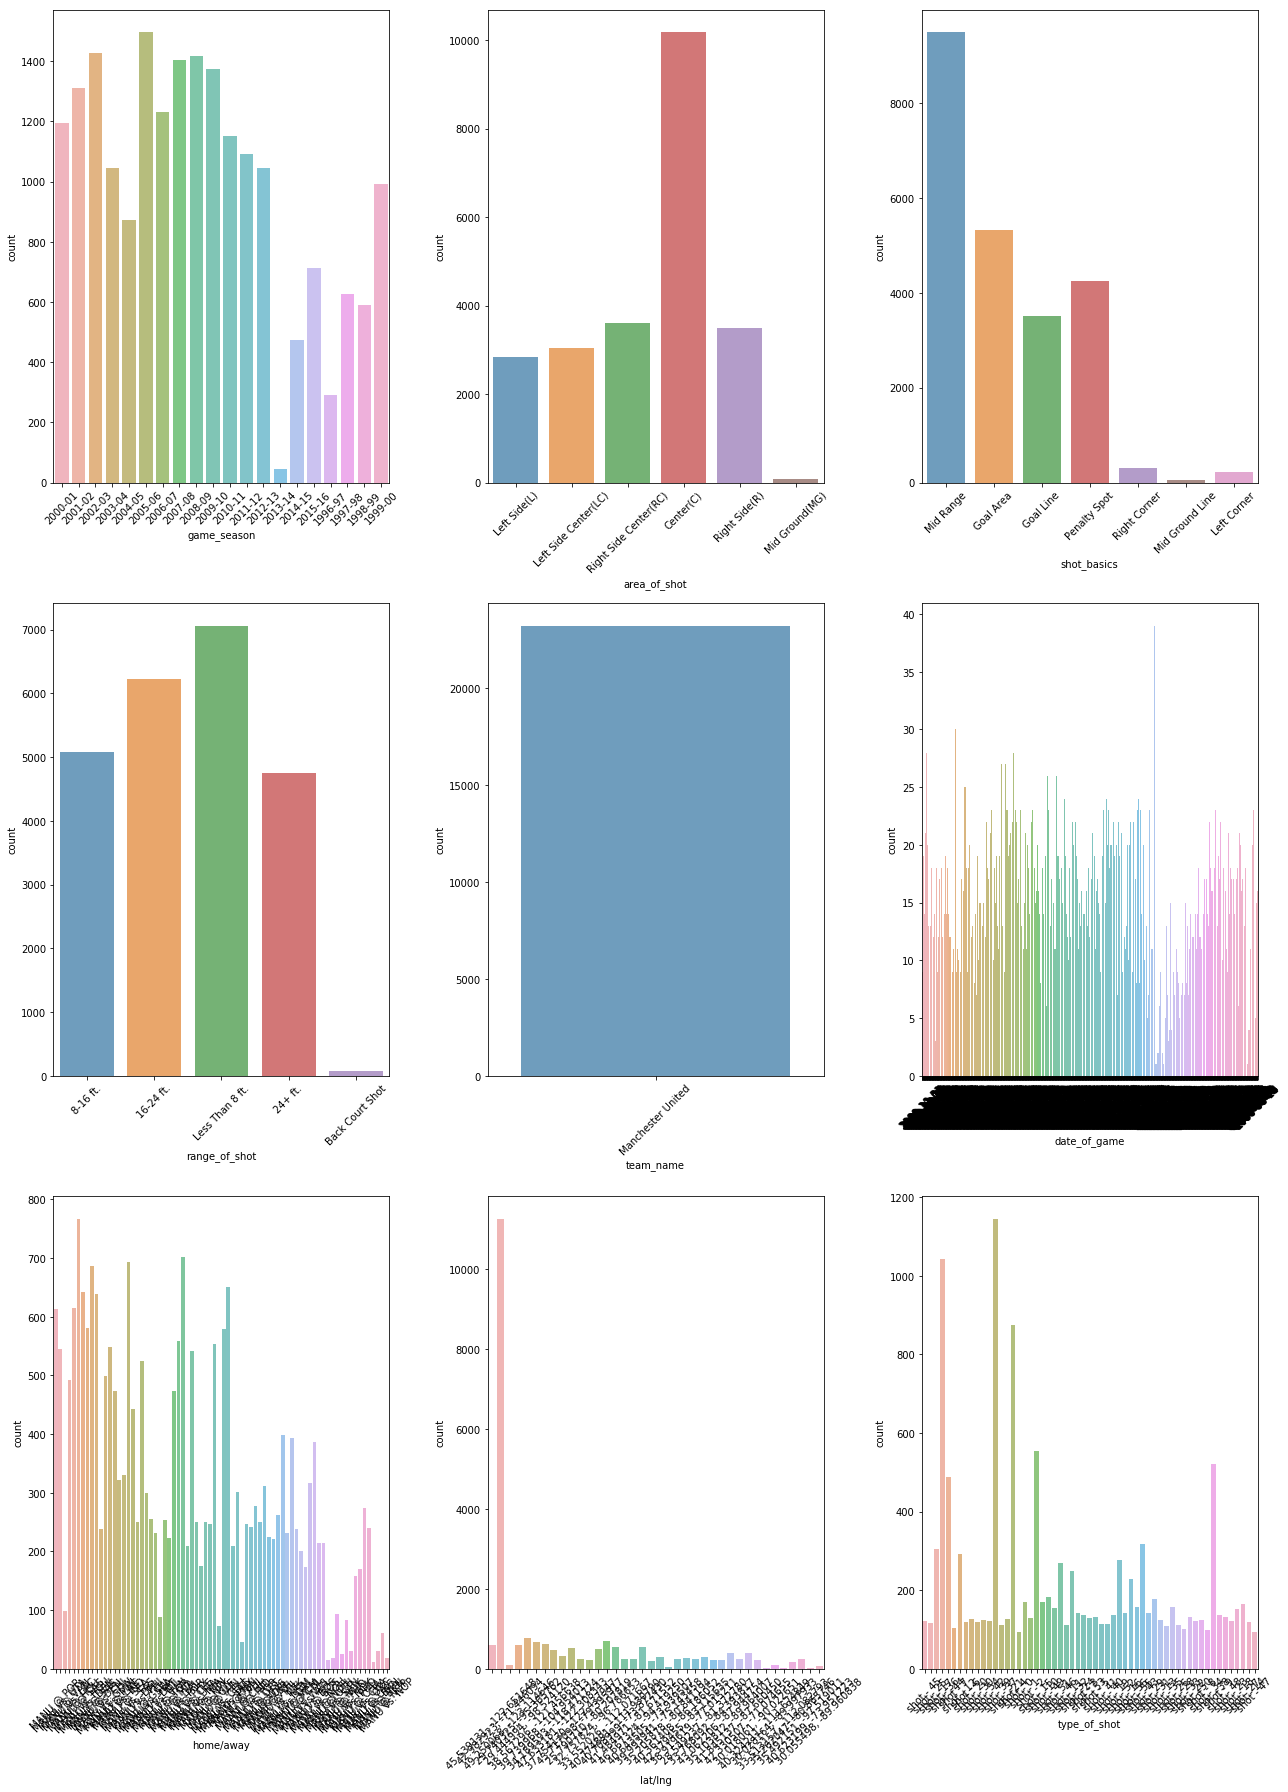

In [23]:
fig, axes = plt.subplots(round(len(df_cat.columns) / 3), 3, figsize=(18, 25))

for i, ax in enumerate(fig.axes):
    if i < len(df_cat.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_cat.columns[i], alpha=0.7, data=df_cat, ax=ax)

fig.tight_layout()

From here we can see that `team_name` is of no use so we will drop that column. Also we can see that date_of_game is not correctly visible so we will explore it more.

In [24]:
# Drop some columns in train and test dataframe

ronaldo_train_df = ronaldo_train_df.drop(['team_name'],axis=1)
ronaldo_test_df = ronaldo_test_df.drop(['team_name'],axis=1)

In [25]:
# Replace NaN values with blank string
ronaldo_train_df['type_of_shot_new'] = ronaldo_train_df.type_of_shot.fillna('',inplace = True)
ronaldo_train_df['type_of_combined_shot_new'] = ronaldo_train_df.type_of_combined_shot.fillna('',inplace = True)

ronaldo_test_df['type_of_shot_new'] = ronaldo_test_df.type_of_shot.fillna('',inplace = True)
ronaldo_test_df['type_of_combined_shot_new'] = ronaldo_test_df.type_of_combined_shot.fillna('',inplace = True)

# Add two columns
ronaldo_train_df['type_of_shot'] = ronaldo_train_df['type_of_shot']+ ronaldo_train_df['type_of_combined_shot']

ronaldo_test_df['type_of_shot'] = ronaldo_test_df['type_of_shot']+ ronaldo_test_df['type_of_combined_shot']

# Drop unnecessary colums

ronaldo_train_df = ronaldo_train_df.drop(['type_of_shot_new','type_of_combined_shot_new','type_of_combined_shot','date_of_game'],axis=1)
ronaldo_test_df = ronaldo_test_df.drop(['type_of_shot_new','type_of_combined_shot_new','type_of_combined_shot','date_of_game'],axis=1)

In [26]:
# delete the numerical and categorical dataframe

del df_num,df_cat

## Missing Values Treatment

1. For `game_season` column we can fill the values using **Last Observation Carried Forward**.

In [27]:
# Fill game_season 

ronaldo_train_df['game_season'] = ronaldo_train_df['game_season'].fillna(method='pad')
ronaldo_test_df['game_season'] = ronaldo_test_df['game_season'].fillna(method='pad')

In [28]:
ronaldo_train_df['is_goal'].value_counts()

0.0    13550
1.0    10879
Name: is_goal, dtype: int64

In [29]:
# Label Encoding for Categorical Variables

for col in ronaldo_train_df.columns:
    if ronaldo_train_df[col].dtype==object:
        print(col)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(ronaldo_train_df[col].values.astype('str')))
        ronaldo_train_df[col] = lbl.transform(list(ronaldo_train_df[col].values.astype('str')))
        ronaldo_test_df[col] = lbl.transform(list(ronaldo_test_df[col].values.astype('str')))

game_season
area_of_shot
shot_basics
range_of_shot
home/away
lat/lng
type_of_shot


In [30]:
# Use 3 nearest rows which have a feature to fill in each row's missing features
X_filled_knn = KNN(k=3).fit_transform(ronaldo_train_df)

Imputing row 1/24429 with 0 missing, elapsed time: 155.023
Imputing row 101/24429 with 1 missing, elapsed time: 155.031
Imputing row 201/24429 with 0 missing, elapsed time: 155.040
Imputing row 301/24429 with 2 missing, elapsed time: 155.048
Imputing row 401/24429 with 0 missing, elapsed time: 155.056
Imputing row 501/24429 with 0 missing, elapsed time: 155.065
Imputing row 601/24429 with 1 missing, elapsed time: 155.072
Imputing row 701/24429 with 0 missing, elapsed time: 155.080
Imputing row 801/24429 with 0 missing, elapsed time: 155.086
Imputing row 901/24429 with 0 missing, elapsed time: 155.094
Imputing row 1001/24429 with 1 missing, elapsed time: 155.100
Imputing row 1101/24429 with 1 missing, elapsed time: 155.108
Imputing row 1201/24429 with 0 missing, elapsed time: 155.117
Imputing row 1301/24429 with 2 missing, elapsed time: 155.126
Imputing row 1401/24429 with 0 missing, elapsed time: 155.132
Imputing row 1501/24429 with 1 missing, elapsed time: 155.140
Imputing row 1601/24

In [31]:
ronaldo_train_df_complete = pd.DataFrame(data = X_filled_knn, columns = ronaldo_train_df.columns)

In [32]:
# Use 3 nearest rows which have a feature to fill in each row's missing features
X_filled_knn_test = KNN(k=3).fit_transform(ronaldo_test_df)

Imputing row 1/6268 with 0 missing, elapsed time: 8.277
Imputing row 101/6268 with 0 missing, elapsed time: 8.281
Imputing row 201/6268 with 1 missing, elapsed time: 8.284
Imputing row 301/6268 with 0 missing, elapsed time: 8.287
Imputing row 401/6268 with 2 missing, elapsed time: 8.291
Imputing row 501/6268 with 2 missing, elapsed time: 8.294
Imputing row 601/6268 with 0 missing, elapsed time: 8.298
Imputing row 701/6268 with 1 missing, elapsed time: 8.301
Imputing row 801/6268 with 1 missing, elapsed time: 8.304
Imputing row 901/6268 with 2 missing, elapsed time: 8.307
Imputing row 1001/6268 with 0 missing, elapsed time: 8.310
Imputing row 1101/6268 with 2 missing, elapsed time: 8.313
Imputing row 1201/6268 with 1 missing, elapsed time: 8.317
Imputing row 1301/6268 with 0 missing, elapsed time: 8.320
Imputing row 1401/6268 with 2 missing, elapsed time: 8.323
Imputing row 1501/6268 with 0 missing, elapsed time: 8.327
Imputing row 1601/6268 with 2 missing, elapsed time: 8.330
Imputing 

In [33]:
ronaldo_test_df_complete = pd.DataFrame(data = X_filled_knn_test, columns = ronaldo_test_df.columns)

In [34]:
train_y = ronaldo_train_df_complete["is_goal"].values

train_X = ronaldo_train_df_complete.drop(['is_goal'],axis=1)
test_X = ronaldo_test_df_complete

# Model Building

In [35]:
train_y = ronaldo_train_df_complete["is_goal"].values

train_X = ronaldo_train_df_complete.drop(['is_goal'],axis=1)
test_X = ronaldo_test_df_complete

del ronaldo_train_df,ronaldo_test_df
print(train_X.shape, test_X.shape)

(24429, 21) (6268, 21)


In [36]:
train_y = train_y.ravel()

In [37]:
train_y.shape

(24429,)

In [38]:
def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None, dep=8, seed=0, data_leaf=200):
    params = {}
    params["objective"] = "binary"
    params['metric'] = 'mae'
    params["max_depth"] = dep
    params["num_leaves"] = 30
    params["min_data_in_leaf"] = data_leaf
    params["learning_rate"] = 0.01
    params["bagging_fraction"] = 0.8
    params["feature_fraction"] = 0.35
    params["feature_fraction_seed"] = seed
    params["bagging_freq"] = 1
    params["bagging_seed"] = seed
    params["lambda_l2"] = 5
    params["lambda_l1"] = 5
    params["verbosity"] = -1
    num_rounds = 20000

    plst = list(params.items())
    lgtrain = lgb.Dataset(train_X, label=train_y)

    if test_y is not None:
        lgtest = lgb.Dataset(test_X, label=test_y)
        model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgtest], early_stopping_rounds=200, verbose_eval=500)
    else:
        lgtest = lgb.DMatrix(test_X)
        model = lgb.train(params, lgtrain, num_rounds)

    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)
    #imps = model.feature_importance()
    #names = model.feature_name()
    #for fi, fn in enumerate(names):
    #    print(fn, imps[fi])

    loss = 0
    if test_y is not None:
        loss = metrics.mean_absolute_error(test_y, pred_test_y)
        print(loss)
        return model, loss, pred_test_y, pred_test_y2
    else:
        return model, loss, pred_test_y, pred_test_y2

In [39]:
print("Building model..")
cv_scores = []
pred_test_full = 0
pred_train = np.zeros(train_X.shape[0])
n_splits = 3
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=7988)
model_name = "lgb"
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.iloc[dev_index,:], train_X.iloc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]

    pred_val = 0
    pred_test = 0
    n_models = 0.

    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, dep=8, seed=2019)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, dep=7, data_leaf=100, seed=9873)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, dep=9, data_leaf=150, seed=4568)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    pred_val /= n_models
    pred_test /= n_models
    
    loss = metrics.mean_absolute_error(val_y, pred_val)
        
    pred_train[val_index] = pred_val
    pred_test_full += pred_test / n_splits
    cv_scores.append(loss)
#     break
print(np.mean(cv_scores))

Building model..
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's l1: 0.459014
[1000]	valid_0's l1: 0.453972
[1500]	valid_0's l1: 0.452096
[2000]	valid_0's l1: 0.451139
[2500]	valid_0's l1: 0.450329
[3000]	valid_0's l1: 0.449829
[3500]	valid_0's l1: 0.449342
[4000]	valid_0's l1: 0.44892
[4500]	valid_0's l1: 0.448474
[5000]	valid_0's l1: 0.448049
Early stopping, best iteration is:
[5072]	valid_0's l1: 0.447998
0.4479981198189364
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's l1: 0.458811
[1000]	valid_0's l1: 0.453941
[1500]	valid_0's l1: 0.451802
[2000]	valid_0's l1: 0.450633
[2500]	valid_0's l1: 0.449982
[3000]	valid_0's l1: 0.449164
[3500]	valid_0's l1: 0.448714
[4000]	valid_0's l1: 0.448204
[4500]	valid_0's l1: 0.447884
[5000]	valid_0's l1: 0.447617
[5500]	valid_0's l1: 0.447335
[6000]	valid_0's l1: 0.447079
[6500]	valid_0's l1: 0.446809
[7000]	valid_0's l1: 0.446574
[7500]	valid_0's l1: 0.446318
[8000]	valid_0's l1: 0.446

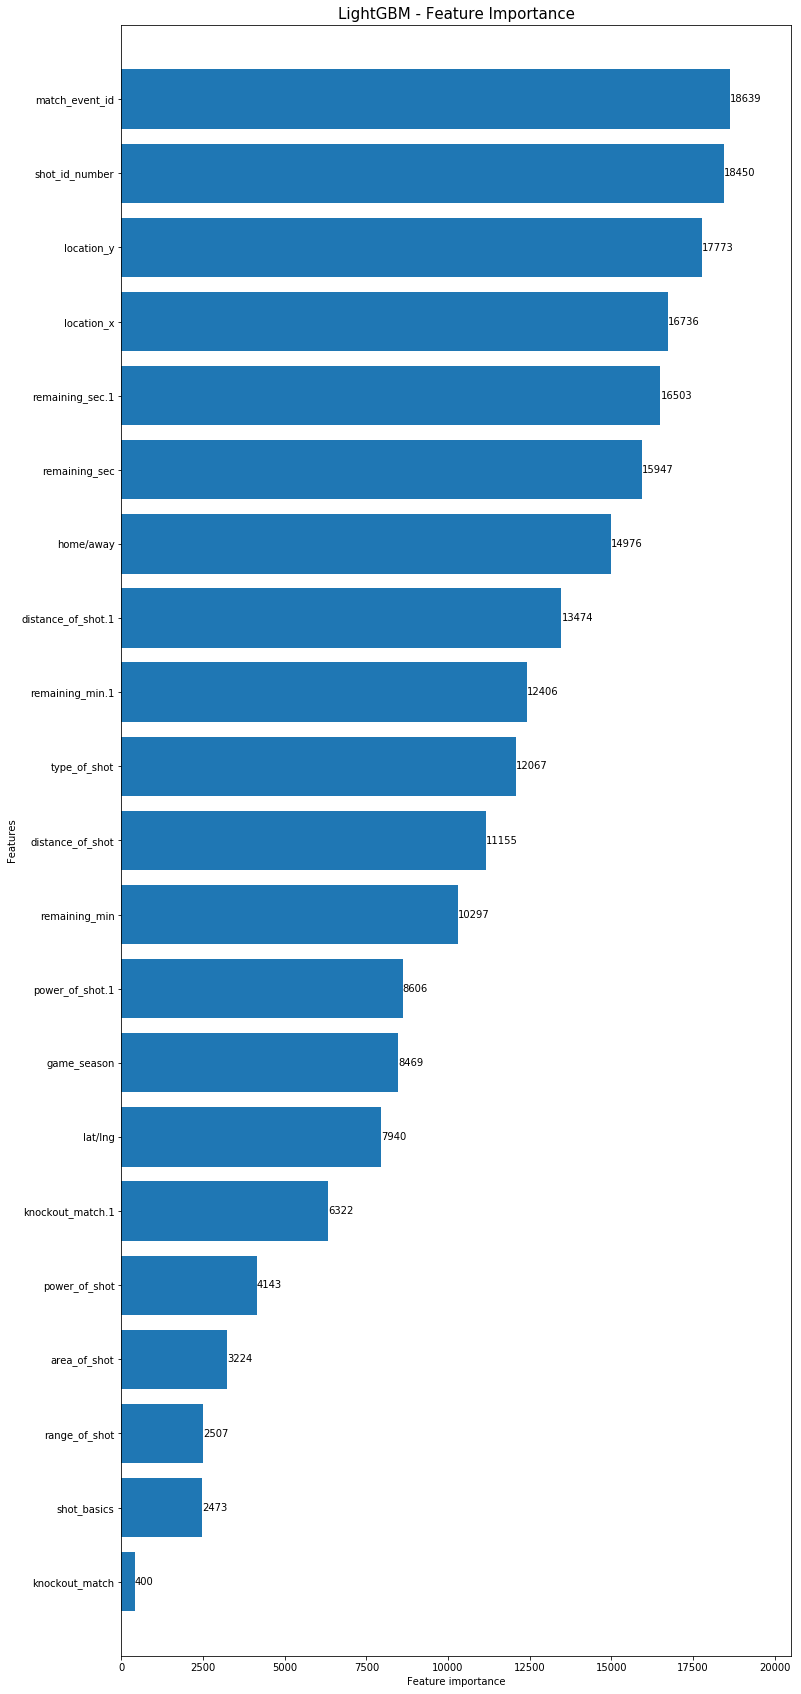

In [40]:
fig, ax = plt.subplots(figsize=(12,30))
lgb.plot_importance(model, max_num_features=100, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [41]:
sub_df = pd.DataFrame(ronaldo_test_df_complete[["shot_id_number"]])
sub_df['shot_id_number'] = sub_df['shot_id_number'].apply(np.int64)
sub_df["is_goal"] = pred_test_full
sub_df['is_goal'] = sub_df['is_goal'].round(1)
sub_df.to_csv("shyam_kumar_251193_prediction_1.csv", index=False)